In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

from pytz import timezone
import datetime as dt

from sklearn.metrics import f1_score
from module.f1_Loss import F1_Loss

In [7]:
# from models.model_kj import resnetbase as MaskModel
from datasets.dataset_kj import basicDatasetA as MaskDataset
# from trans.trans_kj import A_random_trans_no_cut as TrainTrans
# from trans.trans_kj import A_just_tensor as TestTrans

from models.model_bsw import cspdarknet53 as MaskModel
from models.model_bsw import vit_large_patch16_384 as vit_large_patch16_384
from models.model_bsw import vit_small_patch16_224 as vit_small_patch16_224
from trans.trans_bsw import A_random_trans_no_cut as TrainTrans
from trans.trans_bsw import A_just_tensor as TestTrans
from trans.trans_bsw import A_random_trans_no_cut_resize as TrainResize

CLASS_NUM = 18
NUM_WORKERS = 4

# 성능비교를 위해 epoch, batch_size 통일
BATCH_SIZE = 32
NUM_EPOCH = 5 

SAVE_INTERVAL = 2

load_path = ''

comment = ''

In [8]:
c = ''
log = []

test_dir = '/opt/ml/input/data/train'
eval_dir = '/opt/ml/input/data/eval'
save_dir = '/opt/ml/image-classification-level1-25/save/'
now = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y%m%d_%H%M%S"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#======================== model 설정 =============================
import timm

# 사용하기로 정해진 모델은 model_bsw.py에 넣고 모듈을 불러와 사용할 것

model = timm.create_model(model_name= "cspdarknet53",
                                    num_classes = 18, pretrained = True)
                                    
#=================================================================

if load_path : model.load_state_dict(torch.load(load_path))    
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = F1_Loss(classes=CLASS_NUM)
optm = torch.optim.Adam(model.parameters())

TrainTransform = TrainTrans()
TestTransfrom = TestTrans()

dataset_train_mask = MaskDataset(test_dir, mode='train', transform=TrainTransform)
dataset_test_mask = MaskDataset(test_dir, mode='test', transform=TestTransfrom)

dataloader_train_mask = DataLoader(dataset=dataset_train_mask,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      )
dataloader_test_mask = DataLoader(dataset=dataset_test_mask,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      )

dataloaders = {
        "train": dataloader_train_mask,
        "test": dataloader_test_mask
    }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


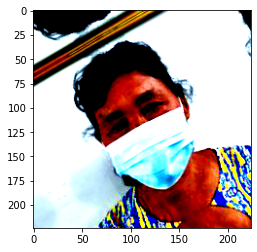

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


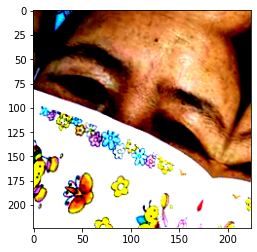

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


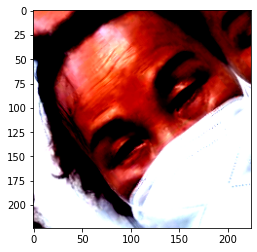

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


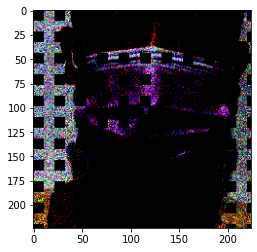

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


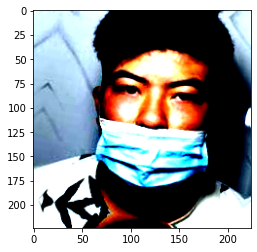

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


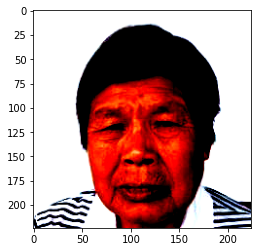

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


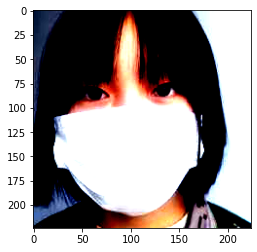

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


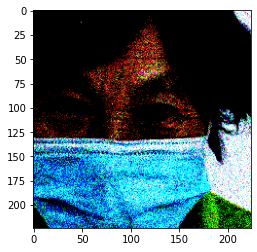

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


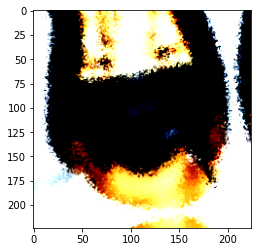

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


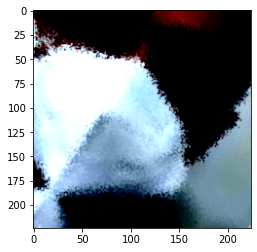

In [9]:
# transform한 이미지 찍어보기
from matplotlib import pyplot as plt

def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def process():
    for batch_idx, (inputs, targets) in enumerate(dataloader_train_mask):
        custom_imshow(inputs[0])
        # 10개만
        if batch_idx == 9:
            break

process()


In [10]:
log.append(f'{c:#^80}')
log.append(f'  [Comment]')
log.append(f'{comment}')
log.append(f'{c:#^80}')
log.append(c); log.append(c); log.append(c)

log.append(f'Model         : {model.__class__.__name__}')
log.append(f'load_state    : {load_path}')
log.append(f'Dataset       : {dataset_train_mask.__class__.__name__}')
log.append(f'train_len     : {len(dataset_train_mask)}')
log.append(f'test_len      : {len(dataset_test_mask)}')
log.append(f'Train_trans   : {TrainTrans.__name__}')
log.append(f'Test_trans    : {TestTrans.__name__}')
log.append(f'Start_Date    : {now}')
log.append(f'Device        : {device}')
log.append(f'CLASS_NUM     : {CLASS_NUM}')
log.append(f'NUM_WORKERS   : {NUM_WORKERS}')
log.append(f'BATCH_SIZE    : {BATCH_SIZE}')
log.append(f'NUM_EPOCH     : {NUM_EPOCH}')
log.append(f'SAVE_INTERVAL : {SAVE_INTERVAL}')


for line in log:
    print(line)
    
log.append(c); log.append(c); log.append(c)

################################################################################
  [Comment]

################################################################################



Model         : VisionTransformer
  load_state  : 
Dataset       : basicDatasetA
  train_len         17010
  test_len           1890
Train_trans   : A_random_trans_no_cut
Test_trans    : A_just_tensor
Start_Date    : 20210830_202744
Device        : cuda:0
CLASS_NUM     : 18
NUM_WORKERS   : 4
BATCH_SIZE    : 32
NUM_EPOCH     : 5
SAVE_INTERVAL : 2


In [11]:
# SAMPLE 복붙
best_test_accuracy = 0.
best_test_loss = float('inf')
best_f1 = 0.

for epoch in range(NUM_EPOCH):
    # for phase in ["test"]:
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        running_f1 = 0.
        
        if phase == "train":
            model.train()
        elif phase == "test":
            model.eval() 
            
        # default image size : 32*3*384*384
        for idx, (images, labels) in enumerate(pbar := tqdm(dataloaders[phase]), start = 1):
 
            images, labels = images.to(device), labels.to(device)

            optm.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                logits = model(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                if phase == "train":
                    loss.backward()  # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optm.step()  # 계산된 gradient를 가지고 모델 업데이트
            
            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)
            running_f1 += f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='macro')
            pbar.set_description(f"loss : {running_loss/(idx*BATCH_SIZE):.3f}, acc : {running_acc/(idx*BATCH_SIZE):.3f}, Macro_f1 : {running_f1/(idx):.3f}")
    
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        epoch_f1 = running_f1 / len(dataloaders[phase])

        log.append(f"[{phase.upper():<5}] Epoch {epoch:0>3d} // (avg) Loss : {epoch_loss:.3f}, Accuracy : {epoch_acc:.3f}, Macro_f1 : {epoch_f1:.5f}")
        print(log[-1])
        
        if phase == "test":
            if best_test_accuracy < epoch_acc:
                best_test_accuracy = epoch_acc
            if best_test_loss > epoch_loss:
                best_test_loss = epoch_loss
            if best_f1 < epoch_f1:
                best_f1 = epoch_f1
            if epoch % SAVE_INTERVAL == 0:
                torch.save(model.state_dict(), os.path.join(save_dir, f'{now}_{model.__class__.__name__}_epoch_{epoch:0>3d}.pt'))

torch.save(model.state_dict(), os.path.join(save_dir, f'{now}_{model.__class__.__name__}_finish_{NUM_EPOCH:0>3d}.pt'))


log.append(c)
print(log[-1])   
log.append(c)
print(log[-1])  
log.append(c)
print(log[-1])  
log.append(f'{c:#^80}')
print(log[-1])            
log.append(f':::학습종료:::')
print(log[-1])
log.append(f"최고 accuracy : {best_test_accuracy:.5f}, 최저 loss : {best_test_loss:.5f}, 최고 Macro_F1 : {best_f1:.5f}")
print(log[-1])
log.append(f'{c:#^80}')
print(log[-1]) 


[TRAIN] Epoch 000 // (avg) Loss : 2.427, Accuracy : 0.196, Macro_f1 : 0.04603


AssertionError: Input image size (512*384) doesn't match model (224*224).

In [10]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image=np.array(image))['image'].float()
        return image

    def __len__(self):
        return len(self.img_paths)

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(eval_dir, 'info.csv'))
image_dir = os.path.join(eval_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, TestTransfrom)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [16]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn

In [11]:
# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(save_dir, f'{now}_result.csv'), index=False)
log.append(f'test inference is done!')
print(log[-1])
log.append(c)
print(log[-1])
log.append(f'{c:-^80}')
print(log[-1])
log.append(c)
print(log[-1])



# log 저장
with open(os.path.join(save_dir, f'{now}.log'), "w") as f:
    now = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y%m%d_%H%M%S"))
    log.append(f'Finish_Date    : {now}')
    print(log[-1])
    for line in log: 
        f.write(line+'\n')

test inference is done!

--------------------------------------------------------------------------------

Finish_Date    : 20210827_171235
